[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/06_the_haunted_dag_and_the_causal_terror.ipynb)

# Chapter 6 - The Haunted Dag and The Causal Terror

## Imports and utility functions

In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 2.X
    
    !pip install --upgrade daft    
    !pip install watermark
    !pip install arviz    
    !pip install causalgraphicalmodels
    
USE_NIGHTLY_TFP = True # @param
if IN_COLAB and USE_NIGHTLY_TFP:
    !pip install --upgrade tf-nightly
    !pip install --upgrade tfp-nightly

In [2]:
%load_ext watermark

In [3]:
# Core
import numpy as np
import arviz as az
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from statsmodels.regression import linear_model

# visualization 
import matplotlib.pyplot as plt

import daft
from causalgraphicalmodels import CausalGraphicalModel

# aliases
tfd = tfp.distributions
tfb = tfp.bijectors
Root = tfd.JointDistributionCoroutine.Root

In [4]:
%watermark -p numpy,tensorflow,tensorflow_probability,arviz,scipy,pandas,statsmodels,daft,causalgraphicalmodels

numpy 1.18.2
tensorflow 2.2.0-dev20200417
tensorflow_probability 0.11.0-dev20200417
arviz 0.7.0
scipy 1.4.1
pandas 1.0.3
statsmodels 0.11.1
daft 0.1.0
causalgraphicalmodels 0.0.4


In [5]:
# config of various plotting libraries
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [6]:
if not USE_NIGHTLY_TFP:
    assert tf.__version__ >= '2.1.0', "Tensorflow version should be at minimum 2.1.0"
    assert tfp.__version__ >= '0.9.0', "TFP version should be at minimum 0.9.0"

### Tensorflow MCMC sampling helpers


In [7]:
USE_XLA = False

In [8]:
NUMBER_OF_CHAINS  = 2
NUMBER_OF_BURNIN  = 500
NUMBER_OF_SAMPLES = 500
NUMBER_OF_LEAPFROG_STEPS = 4

def _trace_to_arviz(trace=None,
                   sample_stats=None,
                   observed_data=None,
                   prior_predictive=None,
                   posterior_predictive=None,
                   inplace=True):

    if trace is not None and isinstance(trace, dict):
        trace = {k: np.swapaxes(v.numpy(), 1, 0)
                 for k, v in trace.items()}
    if sample_stats is not None and isinstance(sample_stats, dict):
        sample_stats = {k: v.numpy().T for k, v in sample_stats.items()}
    if prior_predictive is not None and isinstance(prior_predictive, dict):
        prior_predictive = {k: v[np.newaxis]
                            for k, v in prior_predictive.items()}
    if posterior_predictive is not None and isinstance(posterior_predictive, dict):
        if isinstance(trace, az.InferenceData) and inplace == True:
            return trace + az.from_dict(posterior_predictive=posterior_predictive)
        else:
            trace = None

    return az.from_dict(
        posterior=trace,
        sample_stats=sample_stats,
        prior_predictive=prior_predictive,
        posterior_predictive=posterior_predictive,
        observed_data=observed_data,
    )

@tf.function(autograph=False, experimental_compile=USE_XLA)
def run_chain(init_state,
              bijectors, 
              step_size, 
              target_log_prob_fn, 
              num_leapfrog_steps=NUMBER_OF_LEAPFROG_STEPS,
              num_samples=NUMBER_OF_SAMPLES,
              burnin=NUMBER_OF_BURNIN,
              ):    

    def _trace_fn_transitioned(_, pkr):
        return (
            pkr.inner_results.inner_results.log_accept_ratio
        )

    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                    target_log_prob_fn,
                    num_leapfrog_steps=num_leapfrog_steps,
                    step_size=step_size)         

    inner_kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=hmc_kernel,
        bijector=bijectors)       

    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=inner_kernel,
        target_accept_prob=.8,
        num_adaptation_steps=int(0.8*burnin),
        log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
    )    

    results, sampler_stat = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=burnin,
        current_state=init_state,
        kernel=kernel,
        trace_fn=_trace_fn_transitioned)

    return results, sampler_stat

def sample_posterior(jdc, 
                      observed_data, 
                      params, 
                      num_chains=NUMBER_OF_CHAINS,
                      init_state=None, 
                      bijectors=None,                              
                      num_samples=NUMBER_OF_SAMPLES, 
                      burnin=NUMBER_OF_BURNIN):       
    
    if init_state is None:
        init_state = list(jdc.sample(NUMBER_OF_CHAINS)[:-1])
        
    if bijectors is None:
        bijectors = [tfb.Identity() for i in init_state]


    target_log_prob_fn = lambda *x: jdc.log_prob(x + observed_data)    
    step_size = 0.1
    results, sample_stats = run_chain(init_state,
                                  bijectors,
                                  step_size=step_size,
                                  target_log_prob_fn=target_log_prob_fn,                                      
                                  num_samples=num_samples, 
                                  burnin=burnin)

    stat_names = ['mean_tree_accept']
    sampler_stats = dict(zip(stat_names, [sample_stats]))    
    posterior = dict(zip(params, results))
    return _trace_to_arviz(trace=posterior, sample_stats=sampler_stats)

### DATASET URLS

In [9]:
# You could change base url to local dir or a remoate raw github content
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"

WAFFLE_DIVORCE_DATASET_PATH = f"{_BASE_URL}/WaffleDivorce.csv"
MILK_DATASET_PATH = f"{_BASE_URL}/milk.csv"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"

## Code 6.1


**Berkson's paradox** - A *false* observation of a *negative* coorelation between 2 positive traits.

Members of a population which have some positive trait tend to lack a second even though -:

* The traits may be unrelated

* Or, they may be even positively related.

e.g Resturants at good location have bad food even though location & food have no correlation

Author give another name to **Berkon's paradox**. He calls it **selection-distortion effect**.

The gist of the idea here is that when a sample is selected on a combination of 2 (or more) variables, the relationship between those 2 variables is different after selection than it was before. 


Because of above, author suggests that we should always be cautious of adding more predictor variables to our regression as it may introduce statistical selection with in the model. The phenomenon has a name and it is called **COLLIDER BIAS**.

He suggests to look at the **causal model** as the remedy.

There are actually 3 types of hazards when we add more predictor variables -

* Multicollinearity 
* Post treatment bias
* Collider bias

Collider - a beam in which two particles are made to collide (collision)


In [10]:
# A simulated example to demonstrate selection-disortion 

_SEED = 1914

N = 200
p = 0.1  # proportion to select

# uncorrelated newsworthiness & trustworthiness
seed = tfp.util.SeedStream(_SEED, salt="")
nw = tfd.Normal(loc=0., scale=1.).sample(N, seed=seed()).numpy()
seed = tfp.util.SeedStream(_SEED, salt="")
tw = tfd.Normal(loc=0., scale=1.).sample(N, seed=seed()).numpy()

# select top 10% of combined scores
s = nw + tw  # total score
q = np.quantile(s, 1 - p)  # top 10% threshold

selected = np.where(s >= q, True, False)

np.corrcoef(tw[selected], nw[selected])[0, 1]

-0.828225254885134

## Code 6.2


**Multicollinearity** - when the predictor variables are stronly correlated.

When this happens the posterior distribution will seem to suggest that none of the variables is reliably associated with the outcome. Author says that this happens because of how multiple regression work !!. 


TODO - Investigate above point ie. how multiple regression leads to this.

Author suggest that the model will still infer correct but it would be difficult to understand it.

Here we again create an artifical dataset about height & its relation to the lenght of the legs as predictor variables


In [11]:
_SEED = 909

N = 100

def generate_height_leg_data():
    seed = tfp.util.SeedStream(_SEED, salt="leg_exp")
    height = tfd.Normal(loc=10., scale=2.).sample(N, seed=seed()).numpy()
    leg_prop = tfd.Uniform(low=0.4, high=0.5).sample(N, seed=seed()).numpy()

    # left & right leg as proportion + error
    leg_left = leg_prop * height + tfd.Normal(loc=0, scale=0.02).sample(N, seed=seed()).numpy()

    leg_right = leg_prop * height + tfd.Normal(loc=0, scale=0.02).sample(N, seed=seed()).numpy()

    # build a dataframe using above
    d = pd.DataFrame({
        "height" : height,
        "leg_left" : leg_left,
        "leg_right" : leg_right
    })

    return d

d = generate_height_leg_data()

d.describe()

,height,leg_left,leg_right
count,100.000000,100.000000,100.000000
mean,10.244188,4.586804,4.589090
std,1.971723,0.856999,0.857432
min,6.569585,2.711091,2.734310
25%,8.705090,3.959075,3.970327
50%,10.478082,4.628943,4.644671
75%,11.372977,5.143220,5.147640
max,15.219750,7.189007,7.178730


## Code 6.3 

In [12]:
def model_6_1(leg_left_data, leg_right_data):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=10., scale=100., name="alpha"), sample_shape=1))
      betaL = yield Root(tfd.Sample(tfd.Normal(loc=2., scale=10., name="betaL"), sample_shape=1))
      betaR = yield Root(tfd.Sample(tfd.Normal(loc=2., scale=10., name="betaR"), sample_shape=1))
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))

      mu = tf.squeeze(
          alpha[...,tf.newaxis] + \
          betaL[...,tf.newaxis] * leg_left_data + \
          betaR[...,tf.newaxis] * leg_right_data
      )
        
      scale = sigma[...,tf.newaxis]
        
      height = yield tfd.Independent(
                      tfd.Normal(loc=mu, scale=scale, name="height"), 
                      reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_6_1 = model_6_1(tf.cast(d.leg_left.values, dtype=tf.float32),
                    tf.cast(d.leg_right.values, dtype=tf.float32))

In [13]:
NUM_CHAINS_FOR_6_1 = 2

# Note - 
# I got somewhat ok looking results with this init values
init_state = [
    tf.ones([NUM_CHAINS_FOR_6_1]),
    tf.ones([NUM_CHAINS_FOR_6_1]),
    tf.ones([NUM_CHAINS_FOR_6_1]),
    tf.ones([NUM_CHAINS_FOR_6_1])    
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp()
]

observed_data = (tf.cast(d.height.values, dtype=tf.float32), )

trace_6_1 = sample_posterior(
                jdc_6_1, 
                observed_data=observed_data, 
                num_chains=NUM_CHAINS_FOR_6_1,
                init_state = init_state,
                bijectors = bijectors,
                num_samples=4000,
                burnin=500,
                params=['alpha', 'betaL', 'betaR', 'sigma'])

az.summary(trace_6_1, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.280,0.316,-0.232,0.776,0.036,0.025,78.0,78.0,78.0,104.0,1.04
betaL,1.229,0.693,0.299,2.512,0.229,0.168,9.0,9.0,10.0,18.0,1.23
betaR,0.943,0.691,-0.315,1.876,0.233,0.192,9.0,7.0,9.0,20.0,1.25
sigma,0.661,0.049,0.580,0.733,0.001,0.001,1127.0,1127.0,1070.0,873.0,1.01


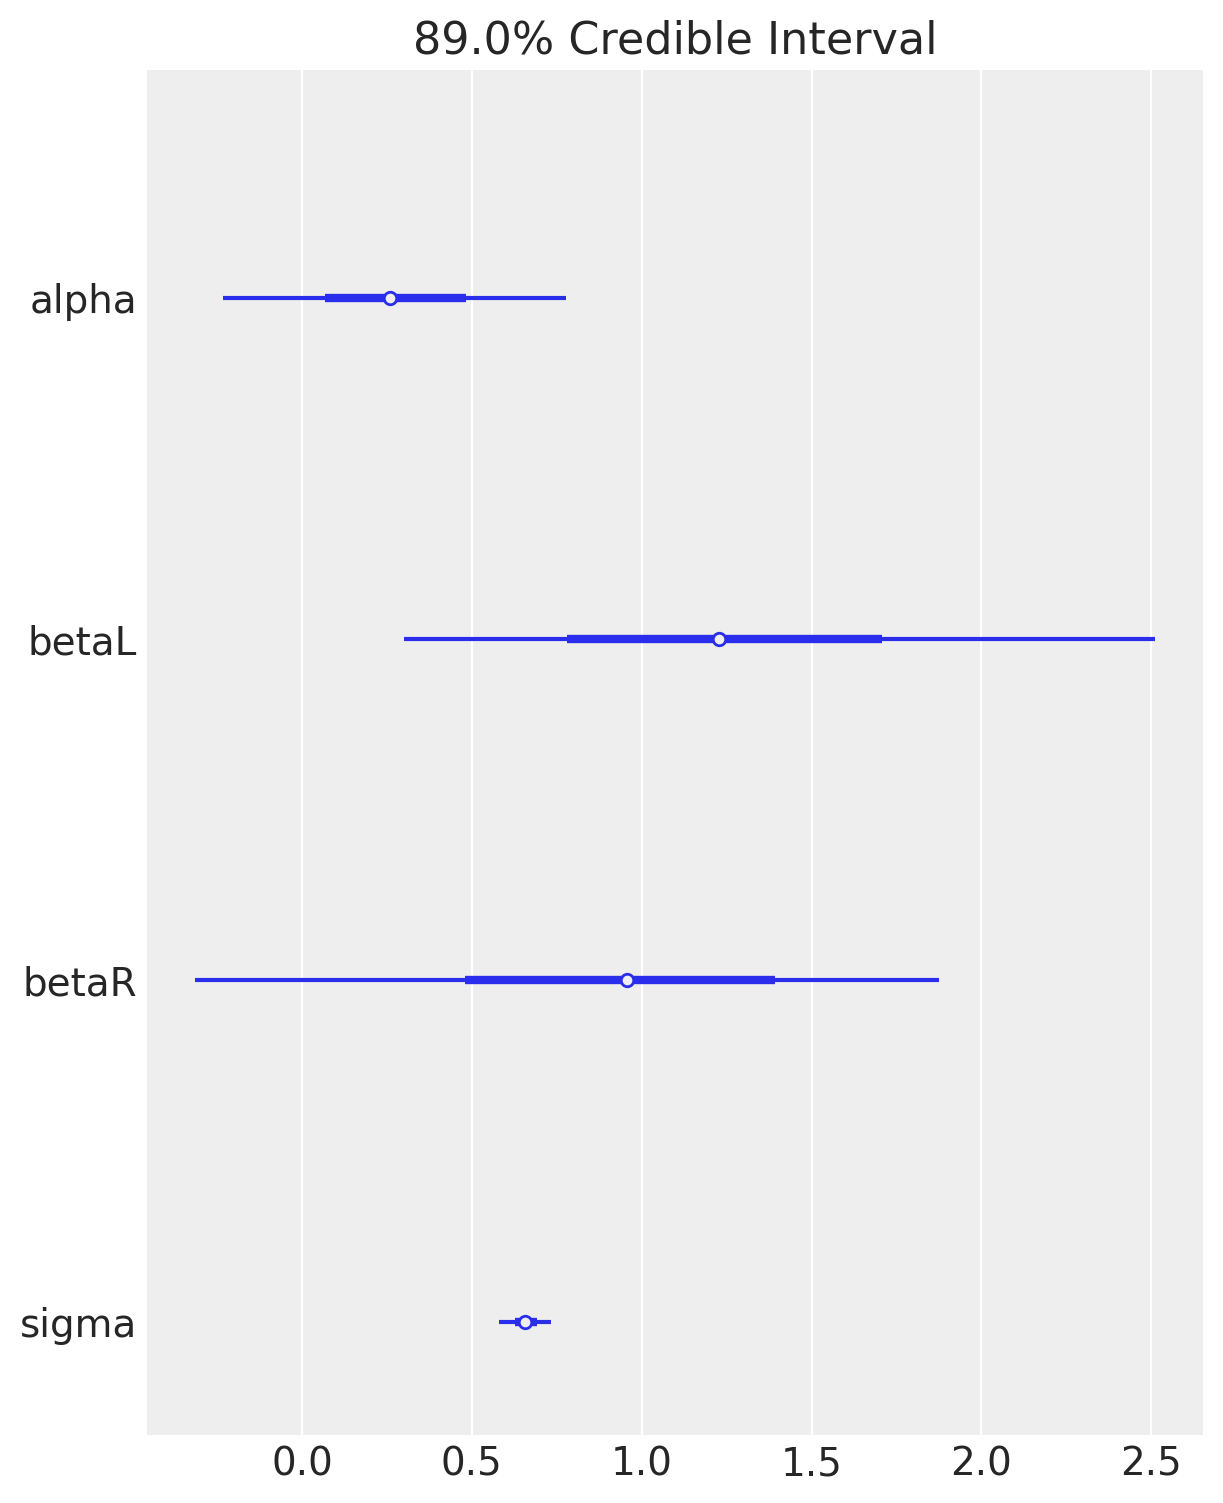

In [14]:
az.plot_forest(trace_6_1, credible_interval=0.89, combined=True);

## Code 6.5 

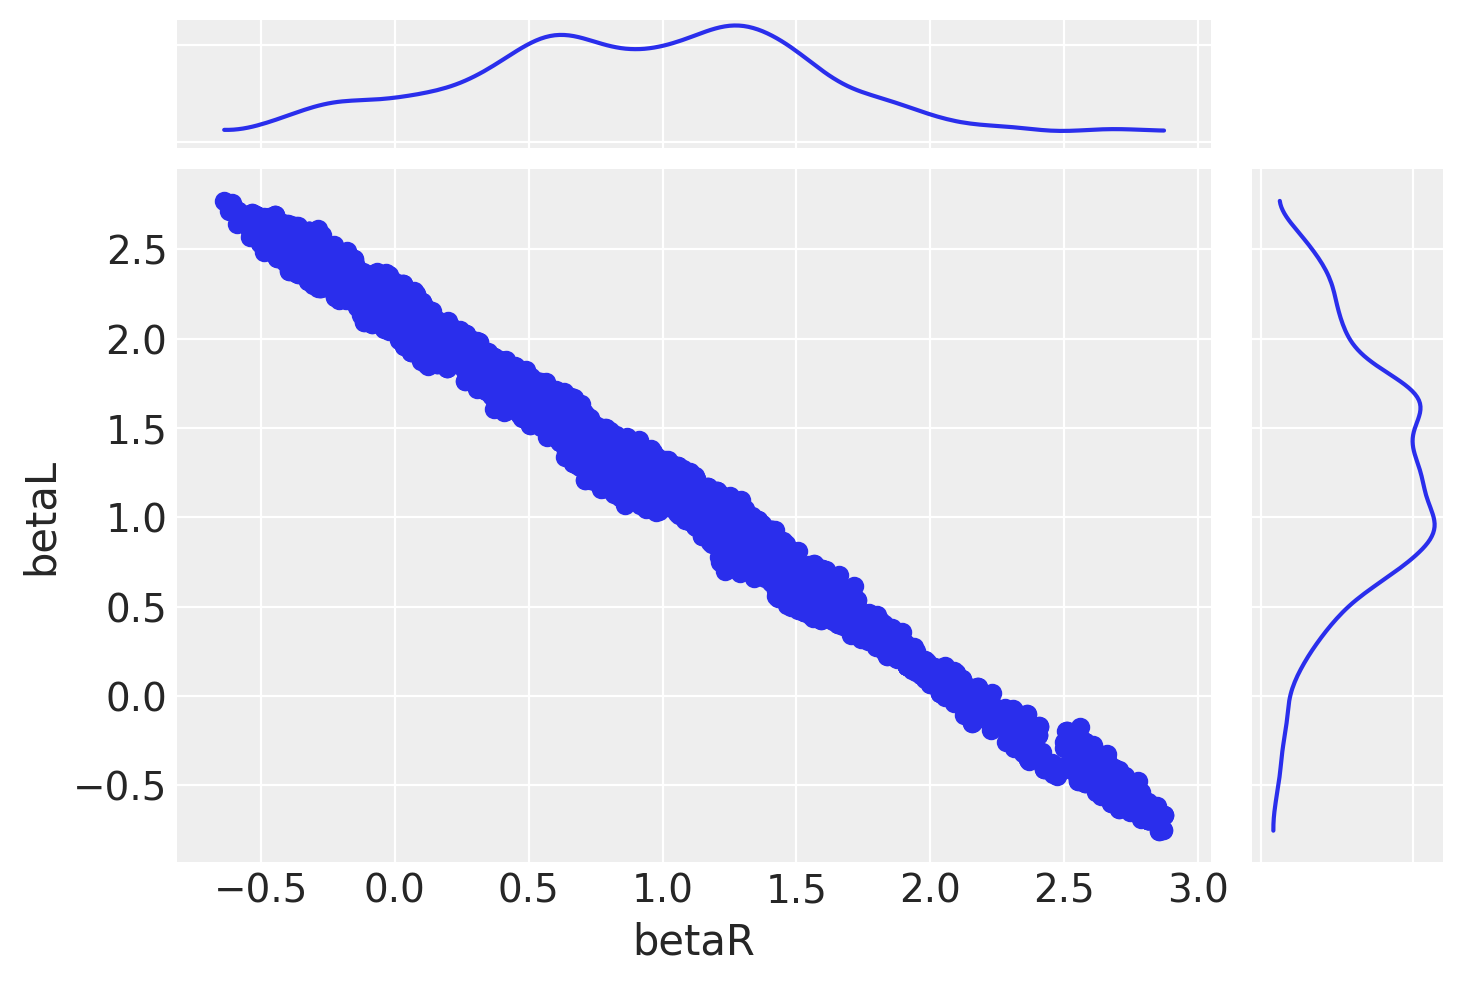

In [15]:
az.plot_joint(trace_6_1, var_names=["betaR", "betaL"]);

## Code 6.6 

In [16]:
posterior_6_1 = trace_6_1.posterior

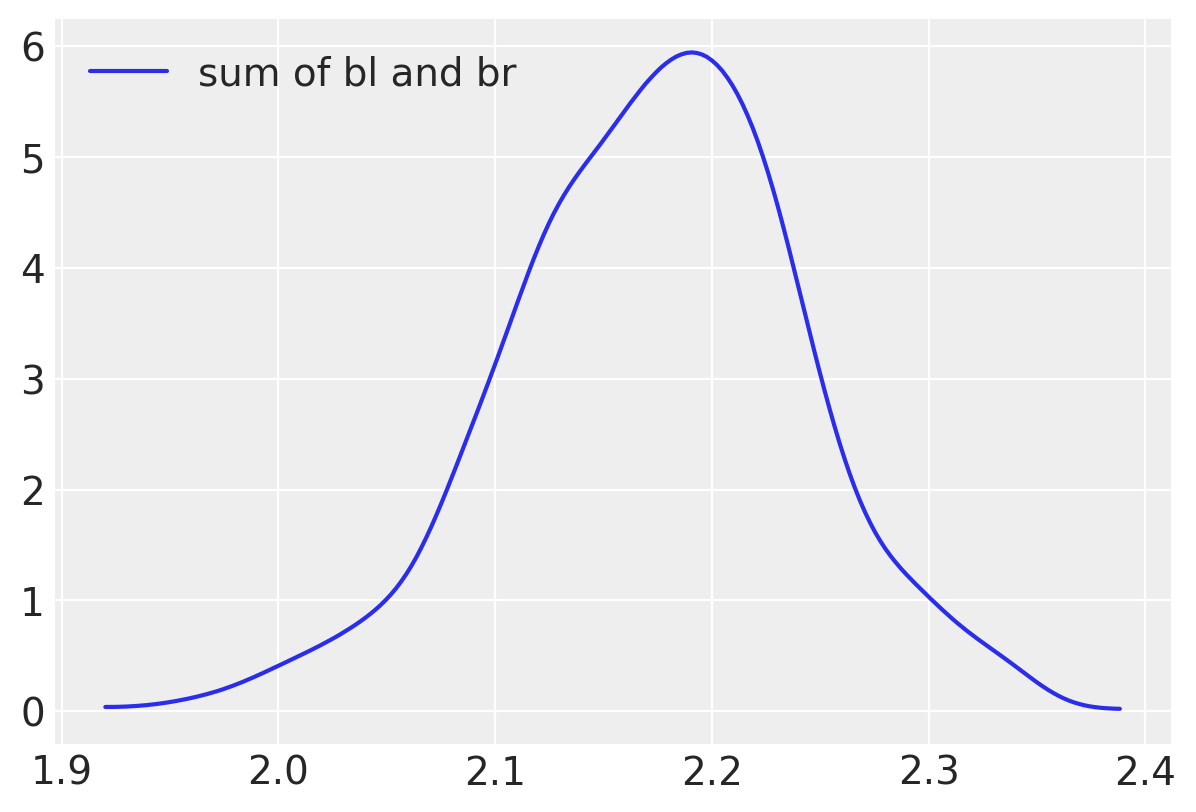

In [17]:
sum_blbr = posterior_6_1["betaL"] + posterior_6_1["betaR"]
az.plot_kde(sum_blbr, label="sum of bl and br");

## Code 6.8

**Multicollinear milk**

In [18]:
d = pd.read_csv(MILK_DATASET_PATH, sep=";")

d["K"] = d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())
d["F"] = d["perc.fat"].pipe(lambda x: (x - x.mean()) / x.std())
d["L"] = d["perc.lactose"].pipe(lambda x: (x - x.mean()) / x.std())

## Code 6.9

We are building here 2 models. 

In [19]:
# KCal is regressed on perc.fat

def model_6_3(per_fat):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alpha"), sample_shape=1))
      betaF = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaF"), sample_shape=1))      
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))    

      mu =  alpha[...,tf.newaxis] + betaF[...,tf.newaxis] * tf.transpose(per_fat[...,tf.newaxis])
      scale = sigma[..., tf.newaxis]  
        
      K = yield tfd.Independent(tfd.Normal(loc=mu, scale=scale, name="K"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_6_3 = model_6_3(tf.cast(d.F.values, dtype=tf.float32))

In [20]:
NUM_CHAINS_FOR_6_3 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_6_3]),
    tf.zeros([NUM_CHAINS_FOR_6_3]),
    tf.ones([NUM_CHAINS_FOR_6_3]),    
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),    
    tfb.Exp()
]

k_values = tf.constant(d.K.values, dtype=tf.float32)

trace_6_3 = sample_posterior(
                    jdc_6_3, 
                    observed_data=(k_values,),
                    init_state = init_state,
                    bijectors = bijectors,
                    params=['alpha', 'betaF', 'sigma'])

In [21]:
# KCal is regressed on perc.lactose

def model_6_4(per_lac):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alpha"), sample_shape=1))
      betaL = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaL"), sample_shape=1))      
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
    
      mu =  alpha[...,tf.newaxis] + betaL[...,tf.newaxis] * tf.transpose(per_lac[...,tf.newaxis])
      scale = sigma[..., tf.newaxis]  
        
      K = yield tfd.Independent(tfd.Normal(loc=mu, scale=scale, name="K"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_6_4 = model_6_4(tf.cast(d.L.values, dtype=tf.float32))

In [22]:
NUM_CHAINS_FOR_6_4 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_6_4]),
    tf.zeros([NUM_CHAINS_FOR_6_4]),
    tf.ones([NUM_CHAINS_FOR_6_4]),    
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),    
    tfb.Exp()
]

trace_6_4 = sample_posterior(
                jdc_6_4, 
                observed_data=(d.K.values,),
                init_state = init_state,
                bijectors = bijectors,
                params=['alpha', 'betaL', 'sigma'])

In [23]:
az.summary(trace_6_3, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.015,0.084,-0.116,0.149,0.011,0.007,64.0,64.0,65.0,110.0,1.05
betaF,0.846,0.093,0.695,0.982,0.006,0.004,268.0,264.0,266.0,410.0,1.03
sigma,0.484,0.069,0.382,0.588,0.002,0.002,930.0,930.0,695.0,135.0,1.01


In [24]:
az.summary(trace_6_4, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.003,0.070,-0.119,0.095,0.006,0.004,137.0,137.0,141.0,186.0,1.01
betaL,-0.898,0.077,-1.014,-0.770,0.006,0.005,143.0,143.0,144.0,165.0,1.02
sigma,0.411,0.057,0.322,0.499,0.002,0.002,673.0,673.0,571.0,99.0,1.01


Posterior for betaF & betaL are mirror images of each other (0.857 vs -0.898)

This seems to imply that both predictors have strong association with the outcome. In next section we will see what happens when we combine both of them in the regression model

## Code 6.10

In [25]:
def model_6_5(per_fat, per_lac):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alpha"), sample_shape=1))
      betaF = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaF"), sample_shape=1))      
      betaL = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaL"), sample_shape=1))      
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
    
      mu =  alpha[...,tf.newaxis] + \
                    betaF[...,tf.newaxis] * tf.transpose(per_fat[...,tf.newaxis]) + \
                    betaL[...,tf.newaxis] * tf.transpose(per_lac[...,tf.newaxis])
    
      scale = sigma[..., tf.newaxis]  
        
      K = yield tfd.Independent(tfd.Normal(loc=mu, scale=scale, name="K"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_6_5 = model_6_5(tf.cast(d.F.values, dtype=tf.float32), 
                    tf.cast(d.L.values, dtype=tf.float32))

In [26]:
NUM_CHAINS_FOR_6_5 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_6_5]),
    tf.zeros([NUM_CHAINS_FOR_6_5]),
    tf.zeros([NUM_CHAINS_FOR_6_5]),
    tf.ones([NUM_CHAINS_FOR_6_5])    
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp()
]

trace_6_5 = sample_posterior(
                    jdc_6_5, 
                    observed_data=(d.K.values,), 
                    num_chains=NUM_CHAINS_FOR_6_5,
                    init_state=init_state,
                    bijectors=bijectors,
                    params=['alpha', 'betaF', 'betaL', 'sigma'])

az.summary(trace_6_5, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.005,0.071,-0.120,0.105,0.004,0.002,409.0,409.0,405.0,361.0,1.00
betaF,0.234,0.190,-0.109,0.505,0.012,0.009,241.0,241.0,243.0,247.0,1.00
betaL,-0.685,0.191,-0.990,-0.372,0.012,0.009,251.0,234.0,252.0,246.0,1.01
sigma,0.412,0.062,0.309,0.494,0.002,0.002,845.0,811.0,874.0,279.0,1.00


Notice how the standard deviations of the posterior for betaF & betaL has jumped up significantly

## Code 6.11



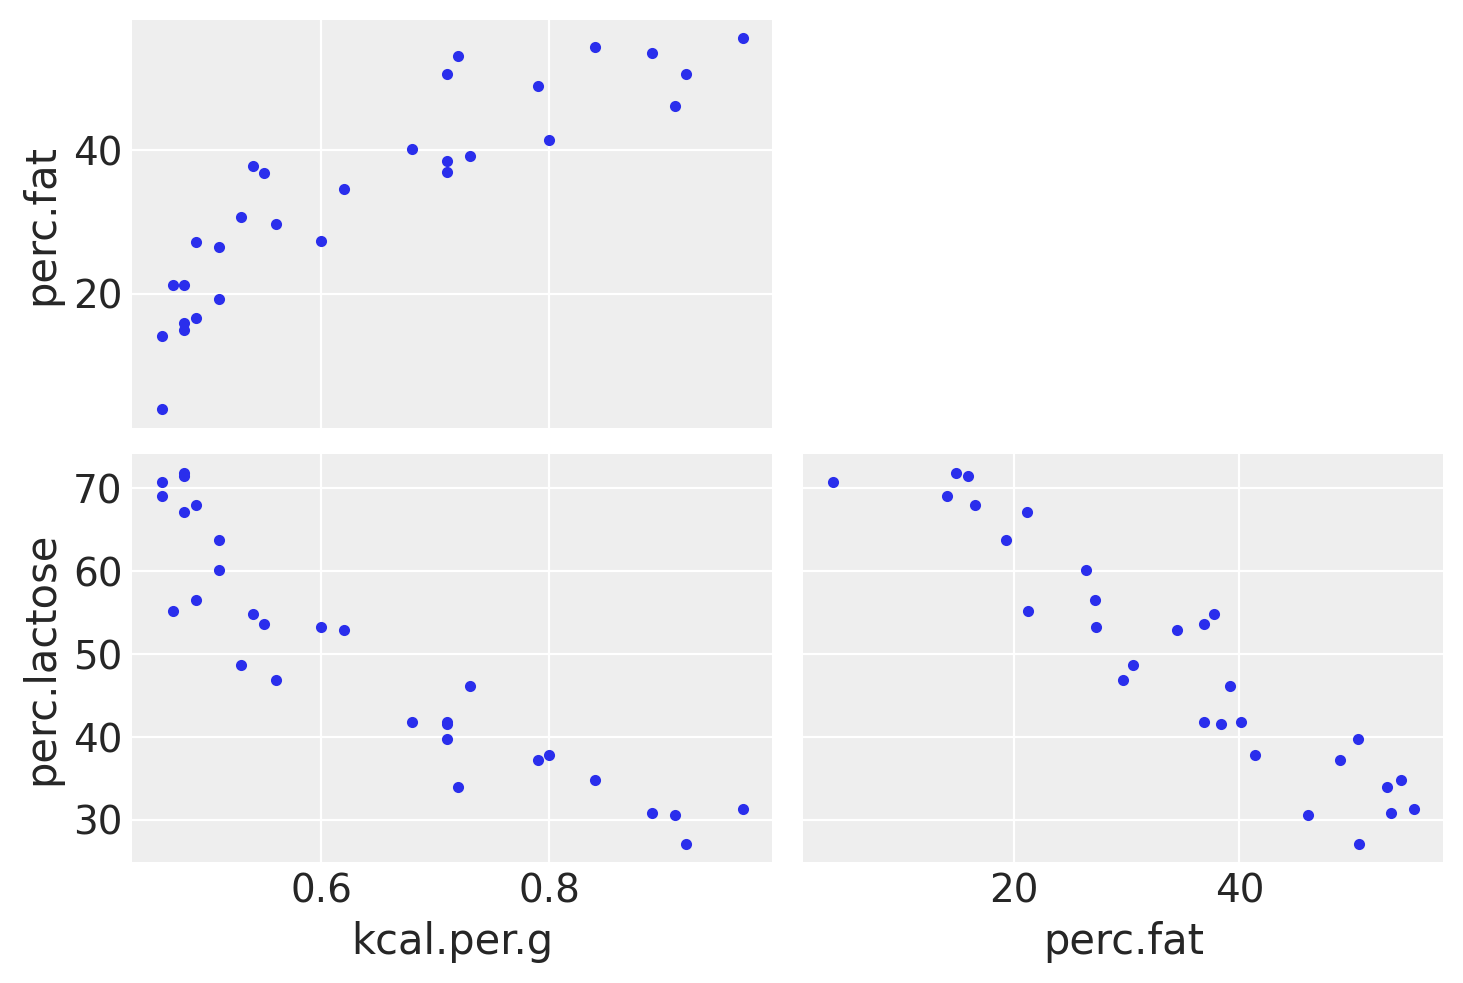

In [27]:
az.plot_pair(d[["kcal.per.g", "perc.fat", "perc.lactose"]].to_dict("list"));

* perc.fat is positively related to outcome

* perc.lac is negatively related to outcome

* perc.fat & perc.lac are negatively coorelated to each other

Either of them helps in predicting KCal but neither helps much once we already know the other.

Author suggests that often before modelling people look at the correlation between variables & drop them if it is the case. He calls this a mistake and suggest that the pairwise correlations are not the problems. 

He argues that it is the conditional association - not correlations - that matter. 

Associations with in data alone are not enough to decide what to do. 

He motivates to look at the problem causally and mentions the existence of an unobserved variable. This type of variable is also called **Non identifiable variable** i.e. the structure of the data & the model does not make it possible to esitmate this parameter's value.

## Code 6.12

Simulating collinearity using Milk dataset

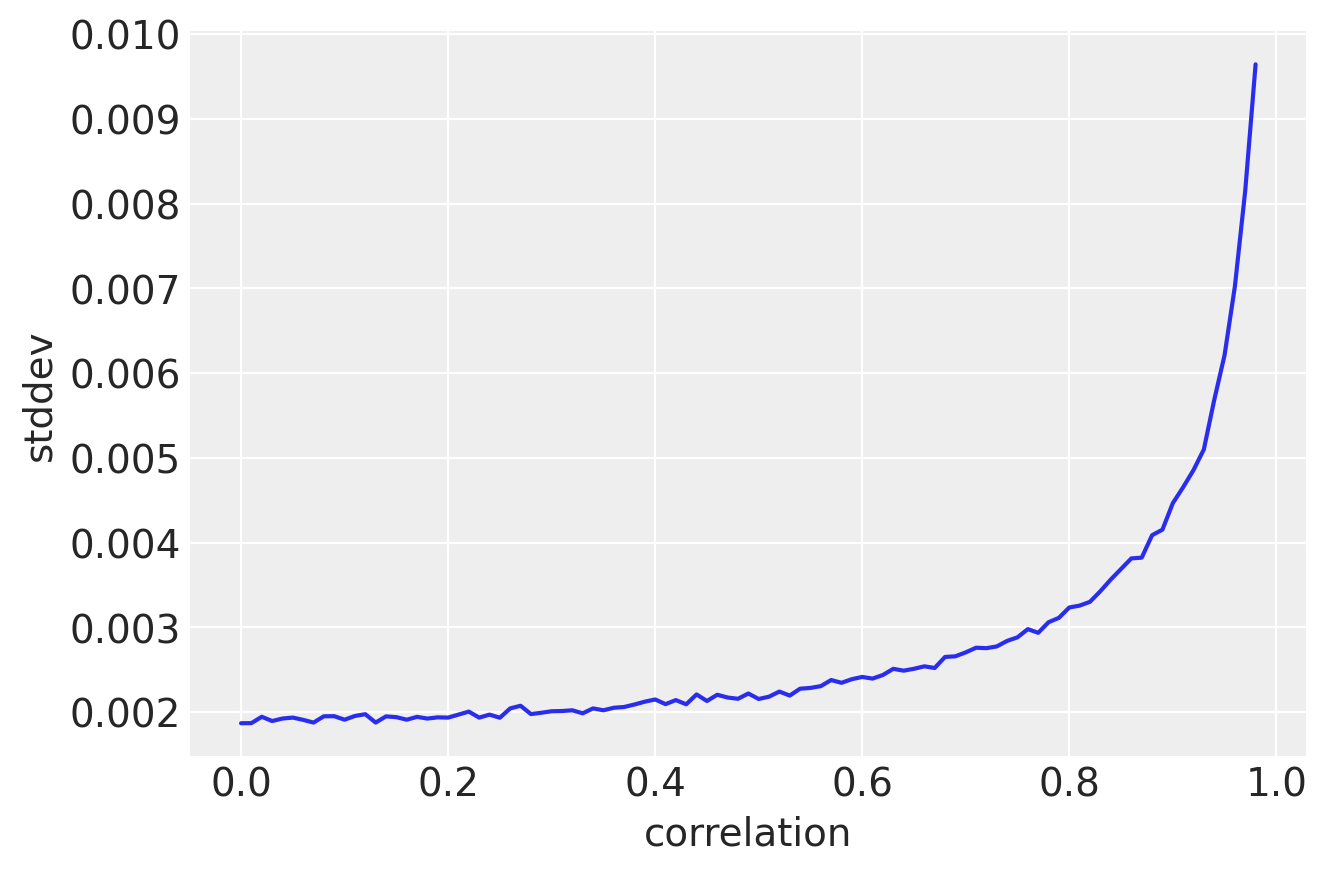

In [28]:
d = pd.read_csv(MILK_DATASET_PATH, sep=";")

def simcoll(r = 0.9):
    
    mean = r * d["perc.fat"].values
    sd = np.sqrt((1 - r ** 2) * np.var(d["perc.fat"].values))
    
    x = tfd.Normal(loc=mean, scale=sd).sample()
    
    X = np.column_stack((d['perc.fat'], x))
    m = linear_model.OLS(d['kcal.per.g'], X).fit()
    cov = m.cov_params()
    return (np.diag(cov)[1])**0.5
    
def repsimcoll(r= 0.9, N = 100):
    stddev = [simcoll(r) for _ in range(N)]
    return np.mean(stddev)

lista = []
for i in np.arange(start = 0, stop = 0.99, step = 0.01):   
    lista.append(repsimcoll (r= i, N = 100))

plt.plot(np.arange(start = 0, stop = 0.99, step = 0.01), lista)
plt.xlabel('correlation', fontsize=14)
plt.ylabel('stddev', fontsize=14);

## Code 6.13

**Omitted Variable bias** - Problems that arise because of **not** including predictior variables

**Post-treatment bias** - Problems that arise becuase of including **improper** predictor variables

In [29]:
_SEED = 71

# Note - even after providing SeedStream and generated seeds
# it still does not respect it
def simulate():
    seed = tfp.util.SeedStream(_SEED, salt="sim_heights")

    # number of plants
    N = 100

    # simulate initial heights
    h0 = tfd.Normal(loc=10., scale=2.).sample(N, seed=seed())

    # assign treatments and simulate fungus and growth
    treatment = tf.repeat([0., 1.], repeats=N // 2)
    
    fungus = tfd.Binomial(total_count=1., probs=(0.5 - treatment * 0.4)).sample(seed=seed())
    
    h1 = h0 + tfd.Normal(loc=5. - 3. * fungus, scale=1.).sample(seed=seed())

    # compose a clean data frame
    d = {"h0":h0, "h1":h1, "treatment":treatment, "fungus":fungus}
    
    return d
    
d = simulate()

az.summary(d, kind="stats", credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%
h0,9.894,2.143,6.421,12.93
h1,13.609,2.696,8.782,17.34
treatment,0.500,0.503,0.000,1.00
fungus,0.350,0.479,0.000,1.00


In [30]:
h0 = d["h0"]
h1 = d["h1"]
treatment = d["treatment"]
fungus = d["fungus"]

## Code 6.14

In [31]:
sim_p = tfd.LogNormal(loc=0., scale=0.25).sample((int(1e4),))
az.summary({"sim_p" : sim_p}, kind="stats", credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%
sim_p,1.033,0.261,0.643,1.431


## Code 6.15

In [32]:
def model_6_6(h0):
    def _generator():
      p = yield Root(tfd.Sample(tfd.LogNormal(loc=0., scale=0.25, name="p"), sample_shape=1))      
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
        
      mu = tf.squeeze(h0[tf.newaxis,...] * p[...,tf.newaxis])
      scale = sigma[..., tf.newaxis]  
        
      h1 = yield tfd.Independent(tfd.Normal(loc=mu, scale=scale, name="h1"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_6_6 = model_6_6(h0)

In [33]:
NUM_CHAINS_FOR_6_6 = 2

init_state = [
    tf.ones([NUM_CHAINS_FOR_6_6]),
    tf.ones([NUM_CHAINS_FOR_6_6])    
]

bijectors = [
    tfb.Exp(),
    tfb.Exp()
]

trace_6_6 = sample_posterior(
                    jdc_6_6, 
                    observed_data=(h1,), 
                    num_chains=NUM_CHAINS_FOR_6_6,
                    init_state=init_state,
                    bijectors=bijectors,
                    num_samples=2000, 
                    burnin=1000,
                    params=['p', 'sigma'])

az.summary(trace_6_6, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,1.356,0.019,1.325,1.386,0.000,0.000,2192.0,2183.0,2217.0,1533.0,1.0
sigma,1.899,0.134,1.687,2.100,0.004,0.003,1113.0,1113.0,1113.0,805.0,1.0


## Code 6.16

In [34]:
def model_6_7(h0, treatment, fungus):
    def _generator():
      a = yield Root(tfd.Sample(tfd.LogNormal(loc=0., scale=0.2, name="a"), sample_shape=1))      
      bt = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="bt"), sample_shape=1))    
      bf = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="bf"), sample_shape=1))    
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
        
      p = a[...,tf.newaxis] + bt[...,tf.newaxis] * treatment + bf[...,tf.newaxis] * fungus
        
      mu = h0 * p
      scale = sigma[..., tf.newaxis]  
        
      h1 = yield tfd.Independent(tfd.Normal(loc=mu, scale=scale, name="h1"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_6_7 = model_6_7(h0, treatment, fungus)

In [35]:
NUM_CHAINS_FOR_6_7 = 2

init_state = [
    tf.ones([NUM_CHAINS_FOR_6_7]),
    tf.zeros([NUM_CHAINS_FOR_6_7]),
    tf.zeros([NUM_CHAINS_FOR_6_7]),
    tf.ones([NUM_CHAINS_FOR_6_7])    
]

bijectors = [
    tfb.Exp(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp()
]

trace_6_7 = sample_posterior(
                    jdc_6_7, 
                    observed_data=(h1,), 
                    num_chains=NUM_CHAINS_FOR_6_7,
                    init_state=init_state,
                    bijectors=bijectors,
                    num_samples=2000, 
                    burnin=1000,
                    params=['a', 'bt', 'bf', 'sigma'])

az.summary(trace_6_7, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.455,0.030,1.410,1.503,0.001,0.001,855.0,851.0,860.0,980.0,1.0
bt,-0.012,0.034,-0.063,0.041,0.001,0.001,1033.0,885.0,1044.0,1072.0,1.0
bf,-0.277,0.036,-0.340,-0.225,0.001,0.001,953.0,932.0,958.0,975.0,1.0
sigma,1.393,0.101,1.224,1.538,0.005,0.003,460.0,460.0,457.0,615.0,1.0


## Code 6.17

In [36]:
def model_6_8(h0, treatment):
    def _generator():
      a = yield Root(tfd.Sample(tfd.LogNormal(loc=0., scale=0.2, name="a"), sample_shape=1))      
      bt = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="bt"), sample_shape=1))    
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
        
      p = a[...,tf.newaxis] + bt[...,tf.newaxis] * treatment 
        
      mu = h0 * p
      scale = sigma[..., tf.newaxis]  
        
      h1 = yield tfd.Independent(tfd.Normal(loc=mu, scale=scale, name="h1"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_6_8 = model_6_8(h0, treatment)

In [37]:
NUM_CHAINS_FOR_6_8 = 2

init_state = [
    tf.ones([NUM_CHAINS_FOR_6_8]),
    tf.zeros([NUM_CHAINS_FOR_6_8]),
    tf.ones([NUM_CHAINS_FOR_6_8])    
]

bijectors = [
    tfb.Exp(),
    tfb.Identity(),
    tfb.Exp()
]

trace_6_8 = sample_posterior(
                    jdc_6_8, 
                    observed_data=(h1,), 
                    num_chains=NUM_CHAINS_FOR_6_8,
                    init_state=init_state,
                    bijectors=bijectors,
                    num_samples=2000, 
                    burnin=1000,
                    params=['a', 'bt', 'sigma'])

az.summary(trace_6_8, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.287,0.026,1.249,1.327,0.000,0.000,2945.0,2934.0,2909.0,1527.0,1.0
bt,0.134,0.035,0.080,0.189,0.001,0.000,3506.0,3506.0,3511.0,1512.0,1.0
sigma,1.791,0.128,1.593,1.994,0.004,0.003,944.0,944.0,937.0,1181.0,1.0


## Code 6.18

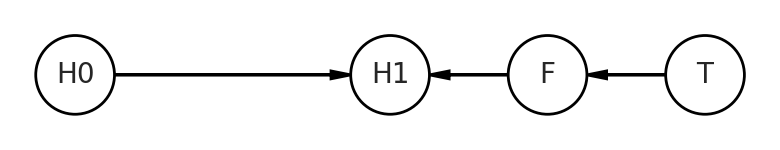

In [38]:
plant_dag = CausalGraphicalModel(
    nodes=["H0", "H1", "F", "T"],
    edges=[("H0", "H1"),
           ("F", "H1"),
           ("T", "F")])
pgm = daft.PGM()
coordinates = {"H0": (0, 0), "T": (4, 0), "F": (3, 0), "H1": (2, 0)}
for node in plant_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in plant_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

## Code 6.19

In [39]:
all_independencies = plant_dag.get_all_independence_relationships()
for s in all_independencies:
    if all(t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
           for t in all_independencies if t != s):
        print(s)

('H0', 'T', set())
('H0', 'F', set())
('T', 'H1', {'F'})


## Code 6.20

In [40]:
_SEED = 71

# Note - even after providing SeedStream and generated seeds
# it still does not respect it
def simulate():
    seed = tfp.util.SeedStream(_SEED, salt="sim_heights")

    # number of plants
    N = 1000

    # simulate initial heights
    h0 = tfd.Normal(loc=10., scale=2.).sample(N, seed=seed())

    # assign treatments and simulate fungus and growth
    treatment = tf.repeat([0., 1.], repeats=N // 2)
    
    M = tf.cast(tfd.Bernoulli(probs=0.5).sample(N, seed=seed()), dtype=tf.float32)
    
    fungus = tfd.Binomial(total_count=1., probs=(0.5 - treatment * 0.4 + M * 0.4)).sample(seed=seed())
    
    h1 = h0 + tfd.Normal(loc=5. + 3. * M, scale=1.).sample(seed=seed())

    # compose a clean data frame
    d = {"h0":h0, "h1":h1, "treatment":treatment, "fungus":fungus}
    
    return d
    
d = simulate()

az.summary(d, kind="stats", credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%
h0,9.994,2.06,6.494,12.935
h1,16.544,2.80,12.268,20.809
treatment,0.500,0.50,0.000,1.000
fungus,0.491,0.50,0.000,1.000


## Code 6.21

Simulating (synthetic data generation) happiness and its relationship with age & marriage

* Each year, 20 people are born with uniformly distributed happiness values
* Each year, each person ages one year. Happiness does not change.
* At age 18, individuals can be married. The odds of marriage each year are proportional to an individual's happiness
* Once married, an individual remains married
* After age 65, individuals leave the sample. (They move to Spain)

In [41]:
# Port of R code from here https://github.com/rmcelreath/rethinking/blob/master/R/sim_happiness.R
def sim_happiness(seed=1977, N_years=1000, max_age=65, N_births=20, aom=18):
    # age existing individuals & newborns
    A = np.repeat(np.arange(1, N_years + 1), N_births)
    # sim happiness trait - never changes
    H = np.repeat(np.linspace(-2, 2, N_births)[None, :], N_years, 0).reshape(-1)
    # not yet married
    M = np.zeros(N_years * N_births, dtype=np.uint8)

    def update_M(i, M):
        # for each person over 17, chance get married
        married = tfd.Bernoulli(logits=(H - 4.)).sample(seed=seed + i).numpy()
        return np.where((A >= i) & (M == 0.), married, M)

    def fori_loop(lower, upper, body_fun, init_val):
        val = init_val
        for i in range(lower, upper):
            val = body_fun(i, val)
        return val
    
    M = fori_loop(aom, max_age+1, update_M, M)    

    # mortality
    deaths = A > max_age
    A = A[~deaths]
    H = H[~deaths]
    M = M[~deaths]

    d = pd.DataFrame({"age": A, "married": M, "happiness": H})
    return d

d = sim_happiness(seed=1977, N_years=1000)

In [42]:
d.describe()

,age,married,happiness
count,1300.000000,1300.000000,1.300000e+03
mean,33.000000,0.292308,-8.335213e-17
std,18.768883,0.454998,1.214421e+00
min,1.000000,0.000000,-2.000000e+00
25%,17.000000,0.000000,-1.000000e+00
50%,33.000000,0.000000,-1.110223e-16
75%,49.000000,1.000000,1.000000e+00
max,65.000000,1.000000,2.000000e+00


In [43]:
# TODO - 
# generate figure 6.4 even though there is no corresponding code cell as it is a nice figure to have in the notebook

## Code 6.22

Rescaling age so that the range from 18 to 65 is one unit

We are adding a new column called "A" that ranges from 0 to 1 where 0 is age 18 and 1 is age 65

Happiness is on an arbitary scale from -2 to +2 

In [44]:
d2 = d[d.age > 17].copy()  # only adults
d2["A"] = (d2.age - 18) / (65 - 18)

## Code 6.23

Doing here multiple regression here. The linear model is 

$\mu_i$ = $\alpha_{MID[i]}$ + $\beta_A$ * $A_i$

In [45]:
d2["mid"] = d2.married

def model_6_9(mid, A):
    def _generator():
      a = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="a"), sample_shape=2))      
      bA = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=2., name="bA"), sample_shape=1))    
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
        
      mu = tf.squeeze(tf.gather(a, mid, axis=-1)) + bA[...,tf.newaxis] * A        
      scale = sigma[..., tf.newaxis]  
        
      h = yield tfd.Independent(tfd.Normal(loc=mu, scale=scale, name="h"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_6_9 = model_6_9(mid=d2.mid.values, A=tf.cast(d2.A.values, dtype=tf.float32))

In [46]:
NUM_CHAINS_FOR_6_9 = 2

init_state = [
    tf.ones([NUM_CHAINS_FOR_6_9, 2]),
    tf.zeros([NUM_CHAINS_FOR_6_9]),
    tf.ones([NUM_CHAINS_FOR_6_9])    
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp()
]

observed_value = (tf.cast(d2.happiness.values, dtype=tf.float32),)

trace_6_9 = sample_posterior(
                    jdc_6_9, 
                    observed_data=observed_value, 
                    num_chains=NUM_CHAINS_FOR_6_9,
                    init_state=init_state,
                    bijectors=bijectors,
                    num_samples=2000, 
                    burnin=1000,
                    params=['a', 'bA', 'sigma'])

az.summary(trace_6_9, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.190,0.064,-0.280,-0.079,0.002,0.001,985.0,985.0,990.0,1334.0,1.0
a[1],1.335,0.087,1.203,1.483,0.003,0.002,857.0,857.0,858.0,1086.0,1.0
bA,-0.828,0.117,-1.016,-0.649,0.004,0.003,745.0,745.0,744.0,1152.0,1.0
sigma,0.989,0.022,0.956,1.026,0.000,0.000,2220.0,2220.0,2208.0,1958.0,1.0


The model here is quite sure that age is negatively associated with happiness.

## Code 6.24

What would happen if omit the marriage status ?

Note - $a$ is not any more a vector; just a plain intercept

In [47]:
def model_6_10(A):
    def _generator():
      a = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="a"), sample_shape=1))      
      bA = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=2., name="bA"), sample_shape=1))    
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
        
      mu = a[...,tf.newaxis] + bA[...,tf.newaxis] * A        
      scale = sigma[..., tf.newaxis]  
        
      h = yield tfd.Independent(tfd.Normal(loc=mu, scale=scale, name="h"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_6_10 = model_6_10(A=tf.cast(d2.A.values, dtype=tf.float32))

In [48]:
NUM_CHAINS_FOR_6_10 = 2

init_state = [
    tf.ones([NUM_CHAINS_FOR_6_10]),
    tf.zeros([NUM_CHAINS_FOR_6_10]),
    tf.ones([NUM_CHAINS_FOR_6_10])    
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp()
]

observed_value = (tf.cast(d2.happiness.values, dtype=tf.float32),)

trace_6_10 = sample_posterior(
                    jdc_6_10, 
                    observed_data=observed_value, 
                    num_chains=NUM_CHAINS_FOR_6_10,
                    init_state=init_state,
                    bijectors=bijectors,
                    num_samples=2000, 
                    burnin=1000,
                    params=['a', 'bA', 'sigma'])

az.summary(trace_6_10, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.076,-0.140,0.108,0.003,0.002,913.0,913.0,915.0,1370.0,1.0
bA,0.000,0.133,-0.215,0.206,0.005,0.003,844.0,844.0,842.0,1160.0,1.0
sigma,1.217,0.028,1.170,1.261,0.001,0.001,1550.0,1546.0,1550.0,1834.0,1.0


The value is $a$ is close to zero. This implies thatthe model finds no association between age and happiness.

The pattern above is exactly what we should expect when condition on a **collider**. Here the **collider** is marriage status. It is a common consequence of age and happiness and therefore if we condition on it we are bound to induce a spurious association between the two causes

## Code 6.25


Collider may not be easily avoidable because they may be unmesasured causes. "Unmeasured" => Our DAG is haunted 

Here we will simulate another dataset using which we will try to infer the direct influene of both parents (P) and grandparents (G) on the educational achievement of childern (C)

It should be obvious that G -> P, P->C and G->C 


In [49]:
N = 200  # number of grandparent-parent-child triads
b_GP = 1.  # direct effect of G on P
b_GC = 0.  # direct effect of G on C
b_PC = 1.  # direct effect of P on C
b_U = 2.  # direct effect of U on P and C

## Code 6.26

Here is our "functional" (relationship) modeling

* P is some function of G & U
* C is some function of G, P & U
* G & U are not functions of any other known variables

In [50]:
def grand_parent_sim():
    seed = tfp.util.SeedStream(1, salt="sim_grand_parent")
    U = 2 * tfd.Bernoulli(probs=0.5).sample(seed=seed(), sample_shape=N) - 1
    G = tfd.Normal(loc=0.,scale=1.).sample(seed=seed(), sample_shape=N)    
    temp = b_GP * G + b_U * tf.cast(U, dtype=tf.float32)    
    P = tfd.Normal(loc=temp,scale=1.).sample(seed=seed())    
    temp2 = b_PC * P + b_GC * G + b_U * tf.cast(U, dtype=tf.float32)  
    C = tfd.Normal(loc=temp2,scale=1.).sample(seed=seed())

    d = pd.DataFrame({"C": C.numpy(), "P": P.numpy(), "G": G.numpy(), "U": U.numpy()})
    
    return d

d = grand_parent_sim()

d

,C,P,G,U
0,3.512862,1.650976,-1.042326,1
1,-4.590997,-1.555232,0.232263,-1
2,4.886199,3.082321,1.986989,1
3,1.636396,1.243976,-1.034003,1
4,-8.797684,-5.349887,-3.269576,-1
...,...,...,...,...
195,3.745021,0.391891,0.254253,1
196,-4.513893,-2.212740,-1.100699,-1
197,-3.206512,-0.455612,0.602985,-1
198,1.082468,-0.115803,0.106212,1


## Code 6.27

Simple regression of C on P & G

In [51]:
def model_6_11(P, G):
    def _generator():
      a = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="a"), sample_shape=1))      
      b_PC = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="b_PC"), sample_shape=1))      
      b_GC = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="b_GC"), sample_shape=1))      
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
       
      mu = a[...,tf.newaxis] + b_PC[...,tf.newaxis] * P + b_GC[...,tf.newaxis] * G    
      scale = sigma[..., tf.newaxis]  
        
      h = yield tfd.Independent(tfd.Normal(loc=mu, scale=scale, name="h"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_6_11 = model_6_11(P=tf.cast(d.P.values, dtype=tf.float32), G=tf.cast(d.G.values, dtype=tf.float32))

In [52]:
NUM_CHAINS_FOR_6_11 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_6_11]),
    tf.ones([NUM_CHAINS_FOR_6_11]),
    tf.ones([NUM_CHAINS_FOR_6_11]),
    tf.ones([NUM_CHAINS_FOR_6_11])    
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp()
]

observed_value = (tf.cast(d.C.values, dtype=tf.float32),)

trace_6_11 = sample_posterior(
                    jdc_6_11, 
                    observed_data=observed_value, 
                    num_chains=NUM_CHAINS_FOR_6_11,
                    init_state=init_state,
                    bijectors=bijectors,
                    num_samples=4000, 
                    burnin=1000,
                    params=['a', 'bPC', 'bGC', 'sigma'])

az.summary(trace_6_11, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.057,0.098,-0.101,0.206,0.001,0.002,9832.0,995.0,9742.0,1502.0,1.0
bPC,1.818,0.045,1.746,1.889,0.001,0.001,3702.0,3690.0,3706.0,3693.0,1.0
bGC,-0.896,0.099,-1.057,-0.748,0.001,0.001,7148.0,6252.0,7264.0,2116.0,1.0
sigma,1.381,0.069,1.267,1.485,0.002,0.001,1325.0,1323.0,1329.0,2121.0,1.0


The inferred effect of parents looks too big, almost twice as large as it should be i.e. 1 vs 1.8

Some correlation between P & C is due to U and that's a simple confound.

Interestingly model is confident (bGC) that the direct effect of grandparents is to hurt their grandkids

## Code 6.28

Regression that conditions on U as well

In [53]:
def model_6_12(P, G, U):
    def _generator():
      a = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="a"), sample_shape=1))      
      b_PC = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="b_PC"), sample_shape=1))      
      b_GC = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="b_GC"), sample_shape=1))      
      b_U = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="b_U"), sample_shape=1))      
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
       
      mu = a[...,tf.newaxis] + \
            b_PC[...,tf.newaxis] * P + \
            b_GC[...,tf.newaxis] * G + \
            b_U[...,tf.newaxis] * U
    
      scale = sigma[..., tf.newaxis]  
        
      h = yield tfd.Independent(tfd.Normal(loc=mu, scale=scale, name="h"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_6_12 = model_6_12(P=tf.cast(d.P.values, dtype=tf.float32), 
                      G=tf.cast(d.G.values, dtype=tf.float32),
                      U=tf.cast(d.U.values, dtype=tf.float32),
                     )

In [54]:
NUM_CHAINS_FOR_6_12 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_6_12]),
    tf.zeros([NUM_CHAINS_FOR_6_12]),
    tf.zeros([NUM_CHAINS_FOR_6_12]),
    tf.ones([NUM_CHAINS_FOR_6_12]),  # <-- note 1 instead of zero here. Necessary !!
    tf.ones([NUM_CHAINS_FOR_6_12])    
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp()
]

observed_value = (tf.cast(d.C.values, dtype=tf.float32),)

trace_6_12 = sample_posterior(
                    jdc_6_12, 
                    observed_data=observed_value, 
                    num_chains=NUM_CHAINS_FOR_6_12,
                    init_state=init_state,
                    bijectors=bijectors,
                    num_samples=4000, 
                    burnin=1000,
                    params=['a', 'bPC', 'bGC', 'bU', 'sigma'])

az.summary(trace_6_12, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.058,0.076,-0.186,0.058,0.001,0.001,6829.0,2129.0,6912.0,2444.0,1.0
bPC,0.928,0.080,0.799,1.052,0.003,0.002,990.0,990.0,994.0,1565.0,1.0
bGC,0.079,0.111,-0.099,0.254,0.003,0.002,1227.0,1227.0,1234.0,1698.0,1.0
bU,2.143,0.172,1.866,2.414,0.006,0.004,944.0,944.0,948.0,1449.0,1.0
sigma,1.032,0.053,0.948,1.116,0.001,0.000,6830.0,6299.0,7800.0,1788.0,1.0


These are similar to the slopes we used to simulate (compare to constants in Code 6.25)

This example is an example of **SIMPSON's PARADOX**. Usually Simpson's paradox is presented in cases where adding the new predictor helps use. But in this case it misleads us. 

## Code 6.29

In [55]:
dag_6_1 = CausalGraphicalModel(
    nodes=["X", "Y", "C", "U", "B", "A"],
    edges=[("X", "Y"), ("U", "X"), ("A", "U"), ("A", "C"),
           ("C", "Y"), ("U", "B"), ("C", "B")])
all_adjustment_sets = dag_6_1.get_all_backdoor_adjustment_sets("X", "Y")
for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
        if s != {"U"}:
            print(s)

frozenset({'A'})
frozenset({'C'})


## Code 6.30

In [56]:
dag_6_2 = CausalGraphicalModel(
    nodes=["S", "A", "D", "M", "W"],
    edges=[("S", "A"), ("A", "D"),
           ("S", "M"), ("M", "D"),
           ("S", "W"), ("W", "D"),
           ("A", "M")])
all_adjustment_sets = dag_6_2.get_all_backdoor_adjustment_sets("W", "D")
for s in all_adjustment_sets:
    if all(not t.issubset(s)for t in all_adjustment_sets if t != s):
        print(s)

frozenset({'S'})
frozenset({'M', 'A'})


## Code 6.31

In [57]:
all_independencies = dag_6_2.get_all_independence_relationships()
for s in all_independencies:
    if all(t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
           for t in all_independencies if t != s):
        print(s)

('W', 'M', {'S'})
('W', 'A', {'S'})
('S', 'D', {'W', 'M', 'A'})
